
<a href="https://colab.research.google.com/github/ernanhughes/boosting-examples/blob/main/Telco-Customer-Churn-Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set()
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    PowerTransformer,
    LabelEncoder,
)

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    f1_score,
    roc_curve,
    auc,
    confusion_matrix,
    roc_curve,
)


import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import shap

import missingno as msno

import warnings

warnings.filterwarnings("ignore")

In [96]:
df = pd.read_csv("./data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [50]:
df.duplicated().sum()

0

In [51]:
def missing(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum() / df.isnull().count()).sort_values(
        ascending=False
    )
    missing_values = pd.concat(
        [missing_number, missing_percent],
        axis=1,
        keys=["Missing_Number", "Missing_Percent"],
    )
    return missing_values


missing(df)

,Missing_Number,Missing_Percent
customerID,0,0.0
DeviceProtection,0,0.0
TotalCharges,0,0.0
MonthlyCharges,0,0.0
PaymentMethod,0,0.0
PaperlessBilling,0,0.0
Contract,0,0.0
StreamingMovies,0,0.0
StreamingTV,0,0.0
TechSupport,0,0.0


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Since customer ID is unique to every user it won't be useful for prediction

In [53]:
df.drop("customerID", axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


No null values are present in this dataset

Here we can observe that even though TotalCharges should be numeric but it is of object type.So converting it to numeric.

In [54]:
# df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors = 'raise')

By applying the conversion to TotalCharges, an error is raised as the column contains "  " (empty) values which cannot be converted to numeric type.<br/>

Hence " " values should be dealt first before model building

In [55]:
len(df[df["TotalCharges"] == " "])

11

Since there are only 11 columns so replacing the values with 0

In [56]:
df["TotalCharges"] = df["TotalCharges"].replace(" ", 0)
# Now converting to numeric dtype
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="raise")
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Now in various categorical columns like 'MultipleLines','InternetService' it can be seen that white space(' ') is present between some category values.Hence replacing the spaces with underscore ('_') will do good for visualisation

In [57]:
df.replace(" ", "_", regex=True, inplace=True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,Yes


## One hot encoding

In [58]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

In [59]:
y.iplot(kind="hist", title="Churn")

In [60]:
le = LabelEncoder()
df["Churn"] = le.fit_transform(df["Churn"])

In [61]:
X.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object

In [62]:
numerical = df.select_dtypes("number").columns
categorical = df.select_dtypes("object").columns
print(f"Numerical Columns:  {df[numerical].columns}")
print("\n")
print(f"Categorical Columns: {df[categorical].columns}")

Numerical Columns:  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn'], dtype='object')


Categorical Columns: Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


In [63]:
df["tenure"] = df["tenure"].astype(float)
numerical = df.select_dtypes("number").columns
df[numerical].describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304,0.265370
std,0.368612,24.559481,30.090047,2266.794470,0.441561
min,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,9.000000,35.500000,398.550000,0.000000
50%,0.000000,29.000000,70.350000,1394.550000,0.000000
75%,0.000000,55.000000,89.850000,3786.600000,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


In [64]:
df[["tenure", "MonthlyCharges", "TotalCharges"]].iplot(
    kind="histogram", subplots=True, bins=50
)

<Axes: >

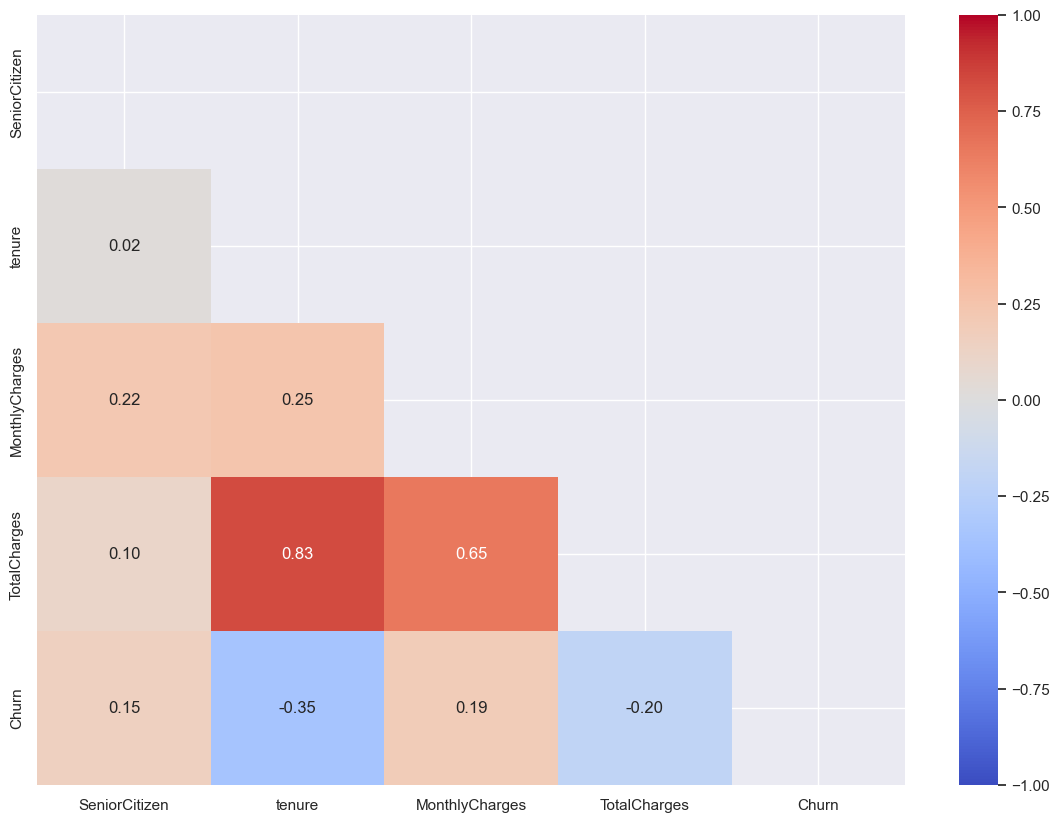

In [65]:
matrix = np.triu(df[numerical].corr())
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(
    df[numerical].corr(),
    annot=True,
    fmt=".2f",
    vmin=-1,
    vmax=1,
    center=0,
    cmap="coolwarm",
    mask=matrix,
    ax=ax,
)

In [66]:
df[categorical].nunique()

gender              2
Partner             2
Dependents          2
PhoneService        2
MultipleLines       3
InternetService     3
OnlineSecurity      3
OnlineBackup        3
DeviceProtection    3
TechSupport         3
StreamingTV         3
StreamingMovies     3
Contract            3
PaperlessBilling    2
PaymentMethod       4
dtype: int64

In [67]:
for feature in df[categorical]:
    print(f"{feature}: {df[feature].unique()}")

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No_phone_service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber_optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No_internet_service']
OnlineBackup: ['Yes' 'No' 'No_internet_service']
DeviceProtection: ['No' 'Yes' 'No_internet_service']
TechSupport: ['No' 'Yes' 'No_internet_service']
StreamingTV: ['No' 'Yes' 'No_internet_service']
StreamingMovies: ['No' 'Yes' 'No_internet_service']
Contract: ['Month-to-month' 'One_year' 'Two_year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic_check' 'Mailed_check' 'Bank_transfer_(automatic)'
 'Credit_card_(automatic)']


In [68]:
print(
    f'A female customer has a probability of {round(df[df["gender"]=="Female"]["Churn"].mean()*100,2)} % churn'
)
print()
print(
    f'A male customer has a probability of {round(df[df["gender"]=="Male"]["Churn"].mean()*100,2)} % churn'
)
print()

A female customer has a probability of 26.92 % churn

A male customer has a probability of 26.16 % churn



In [69]:
fig = px.histogram(df, x="gender", color="Churn", width=400, height=400)
fig.show()

In [70]:
print(
    f'A customer with a partner has a probability of {round(df[df["Partner"]=="Yes"]["Churn"].mean()*100,2)} % churn'
)
print()
print(
    f'A customer without any partner has a probability of {round(df[df["Partner"]=="No"]["Churn"].mean()*100,2)} % churn'
)
print()

A customer with a partner has a probability of 19.66 % churn

A customer without any partner has a probability of 32.96 % churn



In [71]:
fig = px.histogram(df, x="Partner", color="Churn", width=400, height=400)
fig.show()

In [72]:
print(
    f'A customer with dependents has a probability of {round(df[df["Dependents"]=="Yes"]["Churn"].mean()*100,2)} % churn'
)
print()
print(
    f'A customer without any dependents has a probability of {round(df[df["Dependents"]=="No"]["Churn"].mean()*100,2)} % churn'
)
print()

A customer with dependents has a probability of 15.45 % churn

A customer without any dependents has a probability of 31.28 % churn



In [73]:
fig = px.histogram(df, x="Dependents", color="Churn", width=400, height=400)
fig.show()

In [74]:
print(
    f'A customer with a phone service has a probability of {round(df[df["PhoneService"]=="Yes"]["Churn"].mean()*100,2)} % churn'
)
print()
print(
    f'A customer without any phone service has a probability of {round(df[df["PhoneService"]=="No"]["Churn"].mean()*100,2)} % churn'
)
print()
fig = px.histogram(df, x="PhoneService", color="Churn", width=400, height=400)
fig.show()

A customer with a phone service has a probability of 26.71 % churn

A customer without any phone service has a probability of 24.93 % churn



In [75]:
df["MultipleLines"] = df["MultipleLines"].replace("No phone service", "No")

In [76]:
print(
    f'A customer with a multiple lines has a probability of {round(df[df["MultipleLines"]=="Yes"]["Churn"].mean()*100,2)} % churn'
)
print()
print(
    f'A customer without multiple lines has a probability of {round(df[df["MultipleLines"]=="No"]["Churn"].mean()*100,2)} % churn'
)
print()
fig = px.histogram(df, x="MultipleLines", color="Churn", width=400, height=400)
fig.show()

A customer with a multiple lines has a probability of 28.61 % churn

A customer without multiple lines has a probability of 25.04 % churn



In [77]:
print(
    f'A customer with a Fiber Optic internet service has a probability of {round(df[df["InternetService"]=="Fiber optic"]["Churn"].mean()*100,2)} % churn'
)
print()
print(
    f'A customer with a DSL internet service has a probability of {round(df[df["InternetService"]=="DSL"]["Churn"].mean()*100,2)} % churn'
)
print()
print(
    f'A customer without any internet service has a probability of {round(df[df["InternetService"]=="No"]["Churn"].mean()*100,2)} % churn'
)
print()
fig = px.histogram(df, x="InternetService", color="Churn", width=400, height=400)
fig.show()

A customer with a Fiber Optic internet service has a probability of nan % churn

A customer with a DSL internet service has a probability of 18.96 % churn

A customer without any internet service has a probability of 7.4 % churn



In [78]:
accuracy = []
recall = []
roc_auc = []
precision = []

model_names = []

df = pd.read_csv("./data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df1 = df.drop(["customerID", "gender", "PhoneService"], axis=1).copy()
le = LabelEncoder()
df1["Churn"] = le.fit_transform(df1["Churn"])


df1["tenure"] = df1["tenure"].astype(float)
df1["TotalCharges"] = (
    df1["TotalCharges"].apply(lambda x: x if x != " " else np.nan).astype(float)
)

df1[
    [
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
    ]
] = df1[
    [
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
    ]
].replace(
    "No internet service", "No"
)


X = df1.drop("Churn", axis=1)
y = df1["Churn"]

categorical_features_indices = np.where(X.dtypes != float)[0]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

catboost_base = CatBoostClassifier(verbose=False, random_state=0)

catboost_base.fit(
    X_train,
    y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
)
y_pred = catboost_base.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred), 4))
recall.append(round(recall_score(y_test, y_pred), 4))
roc_auc.append(round(roc_auc_score(y_test, y_pred), 4))
precision.append(round(precision_score(y_test, y_pred), 4))

model_names = ["Catboost_default"]
result_df1 = pd.DataFrame(
    {
        "Accuracy": accuracy,
        "Recall": recall,
        "Roc_Auc": roc_auc,
        "Precision": precision,
    },
    index=model_names,
)
result_df1

,Accuracy,Recall,Roc_Auc,Precision
Catboost_default,0.8074,0.5192,0.717,0.6946


In [79]:
accuracy = []
recall = []
roc_auc = []
precision = []


df = pd.read_csv("./data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df1 = df.drop(["customerID", "gender", "PhoneService"], axis=1).copy()
le = LabelEncoder()
df1["Churn"] = le.fit_transform(df1["Churn"])

df1["tenure"] = df1["tenure"].astype(float)
df1["TotalCharges"] = (
    df1["TotalCharges"].apply(lambda x: x if x != " " else np.nan).astype(float)
)

df1[
    [
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
    ]
] = df1[
    [
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
    ]
].replace(
    "No internet service", "No"
)


X = df1.drop("Churn", axis=1)
y = df1["Churn"]

categorical_features_indices = np.where(X.dtypes != float)[0]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

catboost = CatBoostClassifier(verbose=False, random_state=0, scale_pos_weight=3)

catboost.fit(
    X_train,
    y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
)
y_pred = catboost.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred), 4))
recall.append(round(recall_score(y_test, y_pred), 4))
roc_auc.append(round(roc_auc_score(y_test, y_pred), 4))
precision.append(round(precision_score(y_test, y_pred), 4))

model_names = ["Catboost_adjusted_weight_3"]
result_df2 = pd.DataFrame(
    {
        "Accuracy": accuracy,
        "Recall": recall,
        "Roc_Auc": roc_auc,
        "Precision": precision,
    },
    index=model_names,
)
result_df2

,Accuracy,Recall,Roc_Auc,Precision
Catboost_adjusted_weight_3,0.7534,0.8415,0.781,0.529


In [80]:
accuracy = []
recall = []
roc_auc = []
precision = []


df = pd.read_csv("./data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df1 = df.drop(["customerID", "gender", "PhoneService"], axis=1).copy()
le = LabelEncoder()
df1["Churn"] = le.fit_transform(df1["Churn"])

df1["tenure"] = df1["tenure"].astype(float)
df1["TotalCharges"] = (
    df1["TotalCharges"].apply(lambda x: x if x != " " else np.nan).astype(float)
)

df1[
    [
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
    ]
] = df1[
    [
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
    ]
].replace(
    "No internet service", "No"
)


X = df1.drop("Churn", axis=1)
y = df1["Churn"]

categorical_features_indices = np.where(X.dtypes != float)[0]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

catboost_5 = CatBoostClassifier(verbose=False, random_state=0, scale_pos_weight=5)

catboost_5.fit(
    X_train,
    y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
)
y_pred = catboost_5.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred), 4))
recall.append(round(recall_score(y_test, y_pred), 4))
roc_auc.append(round(roc_auc_score(y_test, y_pred), 4))
precision.append(round(precision_score(y_test, y_pred), 4))

model_names = ["Catboost_adjusted_weight_5"]
result_df3 = pd.DataFrame(
    {
        "Accuracy": accuracy,
        "Recall": recall,
        "Roc_Auc": roc_auc,
        "Precision": precision,
    },
    index=model_names,
)
result_df3

,Accuracy,Recall,Roc_Auc,Precision
Catboost_adjusted_weight_5,0.6796,0.9181,0.7544,0.4555


In [81]:
explainercat = shap.TreeExplainer(catboost_5)
shap_values_cat_test = explainercat.shap_values(X_test)
shap_values_cat_train = explainercat.shap_values(X_train)

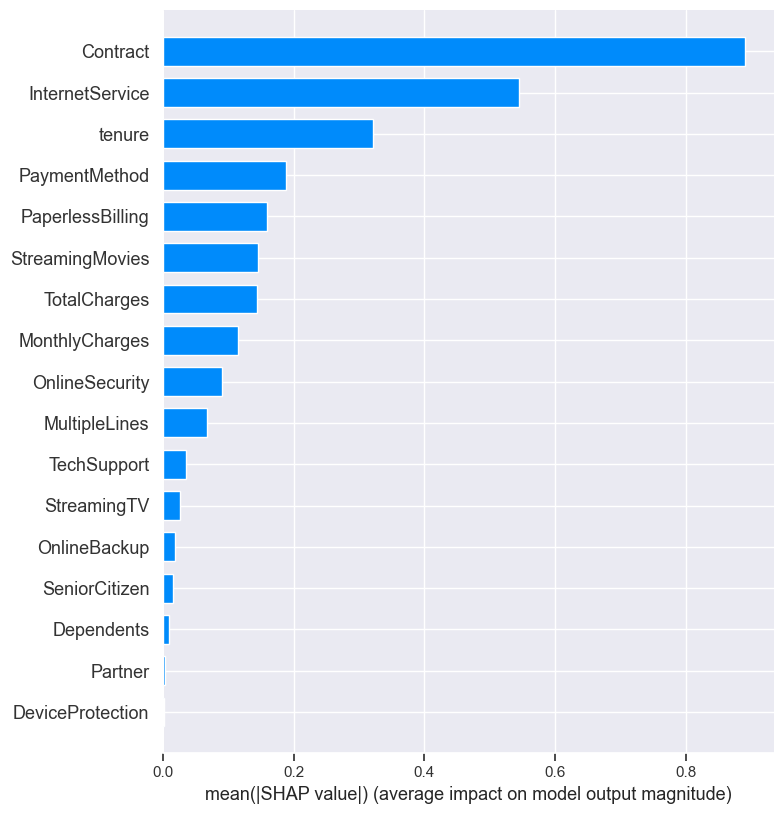

In [82]:
shap.summary_plot(shap_values_cat_train, X_train, plot_type="bar")

In [83]:
accuracy = []
recall = []
roc_auc = []
precision = []


df = pd.read_csv("./data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df1 = df.drop(["customerID", "gender", "PhoneService"], axis=1).copy()
le = LabelEncoder()
df1["Churn"] = le.fit_transform(df1["Churn"])

df1["TotalCharges"] = (
    df1["TotalCharges"].apply(lambda x: x if x != " " else np.nan).astype(float)
)

df1[
    [
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
    ]
] = df1[
    [
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
    ]
].replace(
    "No internet service", "No"
)

df1 = pd.get_dummies(df1)
X = df1.drop("Churn", axis=1)
y = df1["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

xgbc_base = XGBClassifier(random_state=0)

xgbc_base.fit(X_train, y_train)
y_pred = xgbc_base.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred), 4))
recall.append(round(recall_score(y_test, y_pred), 4))
roc_auc.append(round(roc_auc_score(y_test, y_pred), 4))
precision.append(round(precision_score(y_test, y_pred), 4))

model_names = ["XGBoost_Default"]
result_df4 = pd.DataFrame(
    {
        "Accuracy": accuracy,
        "Recall": recall,
        "Roc_Auc": roc_auc,
        "Precision": precision,
    },
    index=model_names,
)
result_df4

,Accuracy,Recall,Roc_Auc,Precision
XGBoost_Default,0.7913,0.5209,0.7065,0.643


In [84]:
accuracy = []
recall = []
roc_auc = []
precision = []


df = pd.read_csv("./data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df1 = df.drop(["customerID", "gender", "PhoneService"], axis=1).copy()
le = LabelEncoder()
df1["Churn"] = le.fit_transform(df1["Churn"])

df1["TotalCharges"] = (
    df1["TotalCharges"].apply(lambda x: x if x != " " else np.nan).astype(float)
)

df1[
    [
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
    ]
] = df1[
    [
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
    ]
].replace(
    "No internet service", "No"
)

df1 = pd.get_dummies(df1)
X = df1.drop("Churn", axis=1)
y = df1["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

xgbc_3 = XGBClassifier(random_state=0, scale_pos_weight=3)

xgbc_3.fit(X_train, y_train)
y_pred = xgbc_3.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred), 4))
recall.append(round(recall_score(y_test, y_pred), 4))
roc_auc.append(round(roc_auc_score(y_test, y_pred), 4))
precision.append(round(precision_score(y_test, y_pred), 4))

model_names = ["XGBoost_adjusted_weight_3"]
result_df5 = pd.DataFrame(
    {
        "Accuracy": accuracy,
        "Recall": recall,
        "Roc_Auc": roc_auc,
        "Precision": precision,
    },
    index=model_names,
)
result_df5

,Accuracy,Recall,Roc_Auc,Precision
XGBoost_adjusted_weight_3,0.7596,0.6742,0.7328,0.5466


In [85]:
accuracy = []
recall = []
roc_auc = []
precision = []


df = pd.read_csv("./data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df1 = df.drop(["customerID", "gender", "PhoneService"], axis=1).copy()
le = LabelEncoder()
df1["Churn"] = le.fit_transform(df1["Churn"])

df1["TotalCharges"] = (
    df1["TotalCharges"].apply(lambda x: x if x != " " else np.nan).astype(float)
)

df1[
    [
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
    ]
] = df1[
    [
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
    ]
].replace(
    "No internet service", "No"
)

df1 = pd.get_dummies(df1)
X = df1.drop("Churn", axis=1)
y = df1["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

xgbc_5 = XGBClassifier(random_state=0, scale_pos_weight=5)

xgbc_5.fit(X_train, y_train)
y_pred = xgbc_5.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred), 4))
recall.append(round(recall_score(y_test, y_pred), 4))
roc_auc.append(round(roc_auc_score(y_test, y_pred), 4))
precision.append(round(precision_score(y_test, y_pred), 4))

model_names = ["XGBoost_adjusted_weight_5"]
result_df6 = pd.DataFrame(
    {
        "Accuracy": accuracy,
        "Recall": recall,
        "Roc_Auc": roc_auc,
        "Precision": precision,
    },
    index=model_names,
)
result_df6

,Accuracy,Recall,Roc_Auc,Precision
XGBoost_adjusted_weight_5,0.7563,0.7387,0.7508,0.5374


In [86]:
explainerxgbc = shap.TreeExplainer(xgbc_5)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)

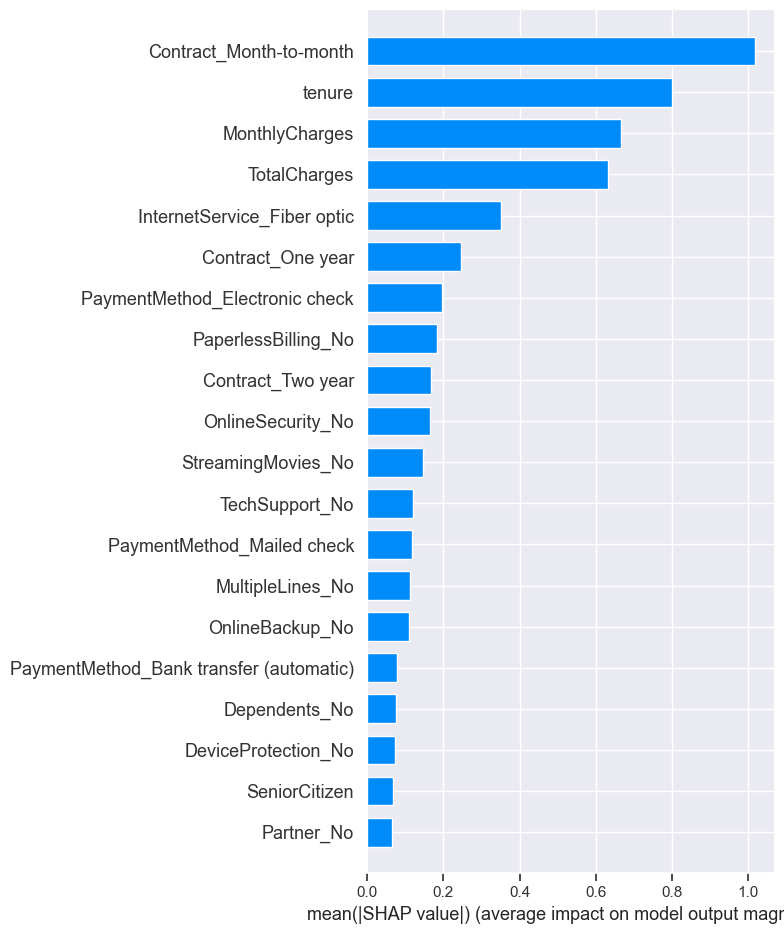

In [87]:
shap.summary_plot(shap_values_XGBoost_train, X_train, plot_type="bar")

In [88]:
accuracy = []
recall = []
roc_auc = []
precision = []


df = pd.read_csv("./data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df1 = df.drop(["customerID", "gender", "PhoneService"], axis=1).copy()
le = LabelEncoder()
df1["Churn"] = le.fit_transform(df1["Churn"])

df1["TotalCharges"] = (
    df1["TotalCharges"].apply(lambda x: x if x != " " else np.nan).astype(float)
)

df1[
    [
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
    ]
] = df1[
    [
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
    ]
].replace(
    "No internet service", "No"
)

df1 = pd.get_dummies(df1)
X = df1.drop("Churn", axis=1)
y = df1["Churn"]

for col in X.columns:
    col_type = X[col].dtype
    if col_type == "object" or col_type.name == "category":
        X[col] = X[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

lgbmc_base = LGBMClassifier(random_state=0)

lgbmc_base.fit(
    X_train,
    y_train,
    categorical_feature="auto",
    eval_set=(X_test, y_test),
    feature_name="auto",
)

y_pred = lgbmc_base.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred), 4))
recall.append(round(recall_score(y_test, y_pred), 4))
roc_auc.append(round(roc_auc_score(y_test, y_pred), 4))
precision.append(round(precision_score(y_test, y_pred), 4))

model_names = ["LightGBM_default"]
result_df7 = pd.DataFrame(
    {
        "Accuracy": accuracy,
        "Recall": recall,
        "Roc_Auc": roc_auc,
        "Precision": precision,
    },
    index=model_names,
)
result_df7

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1295, number of negative: 3635
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.262677 -> initscore=-1.032098
[LightGBM] [Info] Start training from score -1.032098


,Accuracy,Recall,Roc_Auc,Precision
LightGBM_default,0.7998,0.5401,0.7184,0.661


In [89]:
accuracy = []
recall = []
roc_auc = []
precision = []


df = pd.read_csv("./data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df1 = df.drop(["customerID", "gender", "PhoneService"], axis=1).copy()
le = LabelEncoder()
df1["Churn"] = le.fit_transform(df1["Churn"])

df1["TotalCharges"] = (
    df1["TotalCharges"].apply(lambda x: x if x != " " else np.nan).astype(float)
)

df1[
    [
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
    ]
] = df1[
    [
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
    ]
].replace(
    "No internet service", "No"
)

df1 = pd.get_dummies(df1)
X = df1.drop("Churn", axis=1)
y = df1["Churn"]

for col in X.columns:
    col_type = X[col].dtype
    if col_type == "object" or col_type.name == "category":
        X[col] = X[col].astype("category")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

lgbmc_3 = LGBMClassifier(random_state=0, scale_pos_weight=3)

lgbmc_3.fit(
    X_train,
    y_train,
    categorical_feature="auto",
    eval_set=(X_test, y_test),
    feature_name="auto",
)

y_pred = lgbmc_3.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred), 4))
recall.append(round(recall_score(y_test, y_pred), 4))
roc_auc.append(round(roc_auc_score(y_test, y_pred), 4))
precision.append(round(precision_score(y_test, y_pred), 4))

model_names = ["LightGBM_adjusted_weight_3"]
result_df8 = pd.DataFrame(
    {
        "Accuracy": accuracy,
        "Recall": recall,
        "Roc_Auc": roc_auc,
        "Precision": precision,
    },
    index=model_names,
)
result_df8

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1295, number of negative: 3635
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.262677 -> initscore=-1.032098
[LightGBM] [Info] Start training from score -1.032098


,Accuracy,Recall,Roc_Auc,Precision
LightGBM_adjusted_weight_3,0.761,0.7718,0.7644,0.5422


In [90]:
accuracy = []
recall = []
roc_auc = []
precision = []


df = pd.read_csv("./data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df1 = df.drop(["customerID", "gender", "PhoneService"], axis=1).copy()
le = LabelEncoder()
df1["Churn"] = le.fit_transform(df1["Churn"])

df1["TotalCharges"] = (
    df1["TotalCharges"].apply(lambda x: x if x != " " else np.nan).astype(float)
)

df1[
    [
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
    ]
] = df1[
    [
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
    ]
].replace(
    "No internet service", "No"
)

df1 = pd.get_dummies(df1)
X = df1.drop("Churn", axis=1)
y = df1["Churn"]

for col in X.columns:
    col_type = X[col].dtype
    if col_type == "object" or col_type.name == "category":
        X[col] = X[col].astype("category")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

lgbmc_5 = LGBMClassifier(random_state=0, scale_pos_weight=5)

lgbmc_5.fit(
    X_train,
    y_train,
    categorical_feature="auto",
    eval_set=(X_test, y_test),
    feature_name="auto",
)

y_pred = lgbmc_5.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred), 4))
recall.append(round(recall_score(y_test, y_pred), 4))
roc_auc.append(round(roc_auc_score(y_test, y_pred), 4))
precision.append(round(precision_score(y_test, y_pred), 4))

model_names = ["LightGBM_adjusted_weight_5"]
result_df9 = pd.DataFrame(
    {
        "Accuracy": accuracy,
        "Recall": recall,
        "Roc_Auc": roc_auc,
        "Precision": precision,
    },
    index=model_names,
)
result_df9

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1295, number of negative: 3635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.262677 -> initscore=-1.032098
[LightGBM] [Info] Start training from score -1.032098


,Accuracy,Recall,Roc_Auc,Precision
LightGBM_adjusted_weight_5,0.7255,0.831,0.7586,0.4969


In [91]:
explainerlgbmc = shap.TreeExplainer(lgbmc_5)
shap_values_LightGBM_test = explainerlgbmc.shap_values(X_test)
shap_values_LightGBM_train = explainerlgbmc.shap_values(X_train)

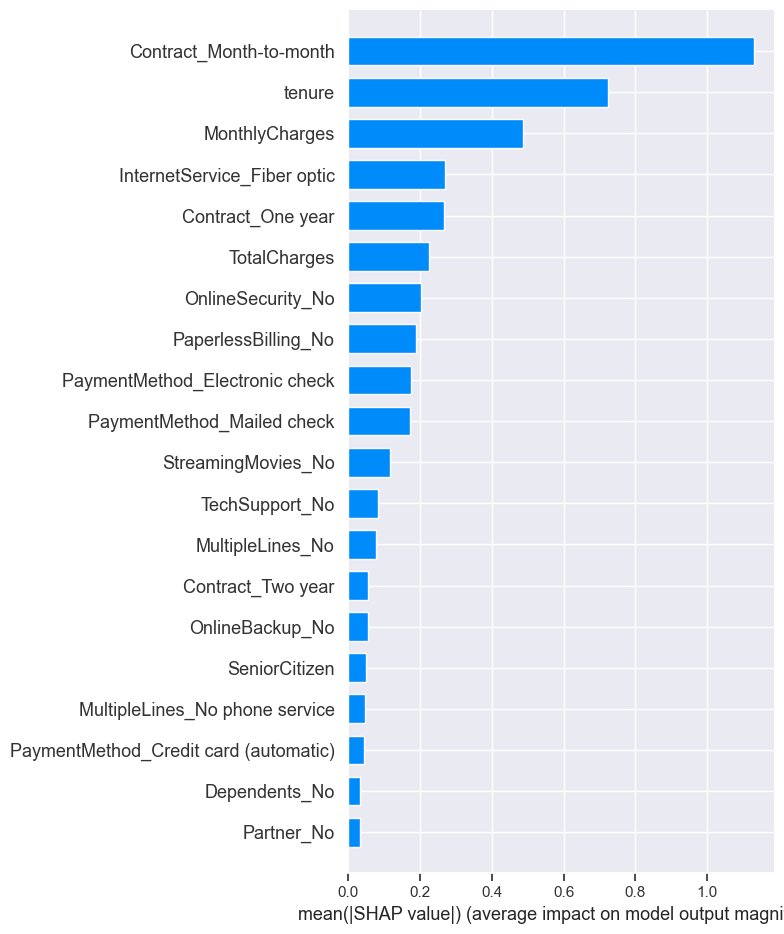

In [92]:
shap.summary_plot(shap_values_LightGBM_train, X_train, plot_type="bar")

In [93]:
result_final = pd.concat(
    [
        result_df1,
        result_df2,
        result_df3,
        result_df4,
        result_df5,
        result_df6,
        result_df7,
        result_df8,
        result_df9,
    ],
    axis=0,
)
result_final

,Accuracy,Recall,Roc_Auc,Precision
Catboost_default,0.8074,0.5192,0.7170,0.6946
Catboost_adjusted_weight_3,0.7534,0.8415,0.7810,0.5290
Catboost_adjusted_weight_5,0.6796,0.9181,0.7544,0.4555
XGBoost_Default,0.7913,0.5209,0.7065,0.6430
XGBoost_adjusted_weight_3,0.7596,0.6742,0.7328,0.5466
XGBoost_adjusted_weight_5,0.7563,0.7387,0.7508,0.5374
LightGBM_default,0.7998,0.5401,0.7184,0.6610
LightGBM_adjusted_weight_3,0.7610,0.7718,0.7644,0.5422
LightGBM_adjusted_weight_5,0.7255,0.8310,0.7586,0.4969


In [94]:
result_final.sort_values(by=["Recall"], ascending=True, inplace=True)
fig = px.bar(
    result_final,
    x="Recall",
    y=result_final.index,
    title="Model Comparison",
    height=600,
    labels={"index": "MODELS"},
)
fig.show()